In [26]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import joblib
import geopandas as gpd
from scipy.stats import pearsonr

In [27]:
# Load zone-level aggregated data (HVFHV only)
PROCESSED_DIR = Path("../input/processed")
EXCLUDED_ZONES = [1, 8, 43, 100, 104, 105, 111, 128, 132, 138, 153, 264, 265]

df_zone = pd.read_parquet(PROCESSED_DIR / "aggregated_data_zone.parquet")
df_zone = df_zone[df_zone['vehicle_type'] == 'hvfhv']
df_zone = df_zone[~df_zone['pulocationid'].isin(EXCLUDED_ZONES)].copy()

print(f"df_zone shape: {df_zone.shape}")
print(f"Unique zones: {df_zone['pulocationid'].nunique()}")

df_zone shape: (251, 84)
Unique zones: 251


# 1. Feature Engineering

- We want to capture why zones have different demand levels
- Only then we compute residuals to assess any service equity gaps

## 1.1 Feature Creation

In [28]:
'''
Commuting columns are useful to measure what percentage of residents are likely to use rideshare apps.
I will aggregate them into a single feature to avoid bloating the model with too many features given number of observations is really limited (only 251)
'''

# Car-dependent commuters (less likely to use rideshare)
df_zone['pct_commute_car'] = (df_zone['commute_drove_alone'] + df_zone['commute_carpooled']) / df_zone['commuters_total']

# Active/flexible commuters (more likely to use rideshare)
df_zone['pct_commute_flexible'] = (df_zone['commute_taxi'] + df_zone['commute_walked'] + df_zone['commute_bicycle']) / df_zone['commuters_total']

# Work from home (less commute-based demand)
df_zone['pct_wfh'] = df_zone['commute_work_from_home'] / df_zone['commuters_total']

# Public Transport Commuters
df_zone['pct_public_transport'] = df_zone['commute_public_transit'] / df_zone['commuters_total']

# Percentage of adults in workforce
df_zone['pct_workforce'] = df_zone['in_labor_force'] / (df_zone['in_labor_force'] + df_zone['not_in_labor_force'])

df_zone['log1p_population'] = np.log1p(df_zone['total_population'])
df_zone['log1p_households'] = np.log1p(df_zone['total_households'])

In [29]:
numerical_features = ['pct_commute_flexible', 'pct_wfh', 'pct_workforce', 'pct_no_vehicle', 'pct_public_transport', 'pct_commute_car', 'log1p_population', 'log1p_households']
categorical_features = ['borough']

## 1.2 Checking for multicollinearity

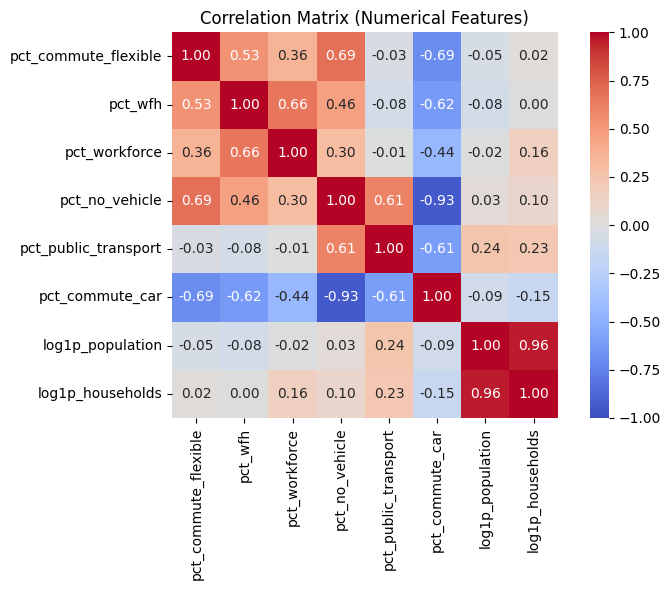

In [30]:
# Correlation matrix for numerical features
corr_matrix = df_zone[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Correlation Matrix (Numerical Features)')
plt.tight_layout()
plt.show()

**Findings:** 
- pct_commute_car and pct_no_vehicle are highly correlated, I will drop pct_commute_car in favor of the more descriptive and general feature
- population and number of households are highly correlated, I will drop the households feature

In [31]:
numerical_features = ['pct_commute_flexible', 'pct_wfh', 'pct_workforce', 'pct_no_vehicle', 'pct_public_transport', 'log1p_population']

## 1.3 Checking for missing information

In [32]:
# Drop rows with missing feature values
feature_cols = numerical_features + categorical_features
rows_before = len(df_zone)

df_zone = df_zone.dropna(subset=feature_cols)
rows_after = len(df_zone)
rows_dropped = rows_before - rows_after
pct_dropped = (rows_dropped / rows_before) * 100 if rows_before else 0

print(f"Dropped rows: {rows_dropped} ({pct_dropped:.2f}%)")
print(f"Remaining rows: {rows_after}")


Dropped rows: 2 (0.80%)
Remaining rows: 249


# 2. Modeling pipelines


In [ ]:
X = df_zone[numerical_features + categorical_features].copy()
y = df_zone['trips_per_capita']

numeric_transformer_lr = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocess_lr = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_lr, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

preprocess_rf = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

lr_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_lr),
    ('model', LinearRegression())
])

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_rf),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid_lr = [
    {'model': [LinearRegression()]},
    {'model': [Ridge()], 'model__alpha': [0.01, 0.1, 1.0, 10.0]}
]

param_grid_rf = {
    'model__n_estimators': [200, 300],
    'model__max_depth': [None, 2, 4, 6, 8],
    'model__min_samples_leaf': [1, 2, 3],
    'model__min_samples_split': [2, 5, 7, 10],
    'model__max_features': ['sqrt', 'log2', 0.5, 1.0]
}

grid_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring='r2', n_jobs=-1)
grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)


## 2.1 GridSearchCV with 5 Folds

In [34]:
MODELS_DIR = Path("../output/models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Fit models
grid_lr.fit(X, y)
grid_rf.fit(X, y)

# CV performance
print(f"Linear model CV R^2: {grid_lr.best_score_:.3f} +/- {grid_lr.cv_results_['std_test_score'][grid_lr.best_index_]:.3f}")
print(f"Random forest CV R^2: {grid_rf.best_score_:.3f} +/- {grid_rf.cv_results_['std_test_score'][grid_rf.best_index_]:.3f}")

# Best params
best_params_lr = grid_lr.best_params_
best_params_rf = grid_rf.best_params_
print("Best LR params:", best_params_lr)
print("Best RF params:", best_params_rf)

# Save models
joblib.dump(grid_lr.best_estimator_, MODELS_DIR / "linear_model_best.joblib")
joblib.dump(grid_rf.best_estimator_, MODELS_DIR / "random_forest_best.joblib")


Linear model CV R^2: 0.434 +/- 0.249
Random forest CV R^2: 0.558 +/- 0.205
Best LR params: {'model': Ridge(), 'model__alpha': 10.0}
Best RF params: {'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


['..\\output\\models\\random_forest_best.joblib']

# 3. Fit models and compute residuals


In [35]:
# Use best estimators from GridSearchCV to compute residuals
# Note: We excluded Lasso from the param grid because:
# 1. Lasso can zero out feature coefficients, making residual interpretation harder
# 2. With only 249 observations and 6 features, Ridge's L2 regularization provides
#    sufficient shrinkage without eliminating predictors entirely
# 3. We want all features to contribute to predictions for more stable residuals

# The RF param grid is already conservative (limited max_depth, higher min_samples_leaf/split)
# to prevent overfitting on this small dataset, so we can use the best estimator directly

ridge_pipeline = grid_lr.best_estimator_
rf_pipeline = grid_rf.best_estimator_

ridge_pipeline.fit(X, y)
rf_pipeline.fit(X, y)

df_zone['residual_ridge'] = y - ridge_pipeline.predict(X)
df_zone['residual_rf'] = y - rf_pipeline.predict(X)

print('Residuals computed: residual_ridge, residual_rf')
print(f'Ridge model: {grid_lr.best_params_}')
print(f'RF model: {grid_rf.best_params_}')

Residuals computed: residual_ridge, residual_rf
Ridge model: {'model': Ridge(), 'model__alpha': 10.0}
RF model: {'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


# 4. Residual equity analysis


         residual        variable         r        r2   p_value
0  residual_ridge    poverty_rate  0.009245  0.000085  0.884593
1  residual_ridge  pct_low_income  0.008630  0.000074  0.892216
2  residual_ridge    pct_minority  0.095379  0.009097  0.133378
3     residual_rf    poverty_rate -0.066601  0.004436  0.295185
4     residual_rf  pct_low_income -0.069753  0.004866  0.272867
5     residual_rf    pct_minority -0.029787  0.000887  0.639953


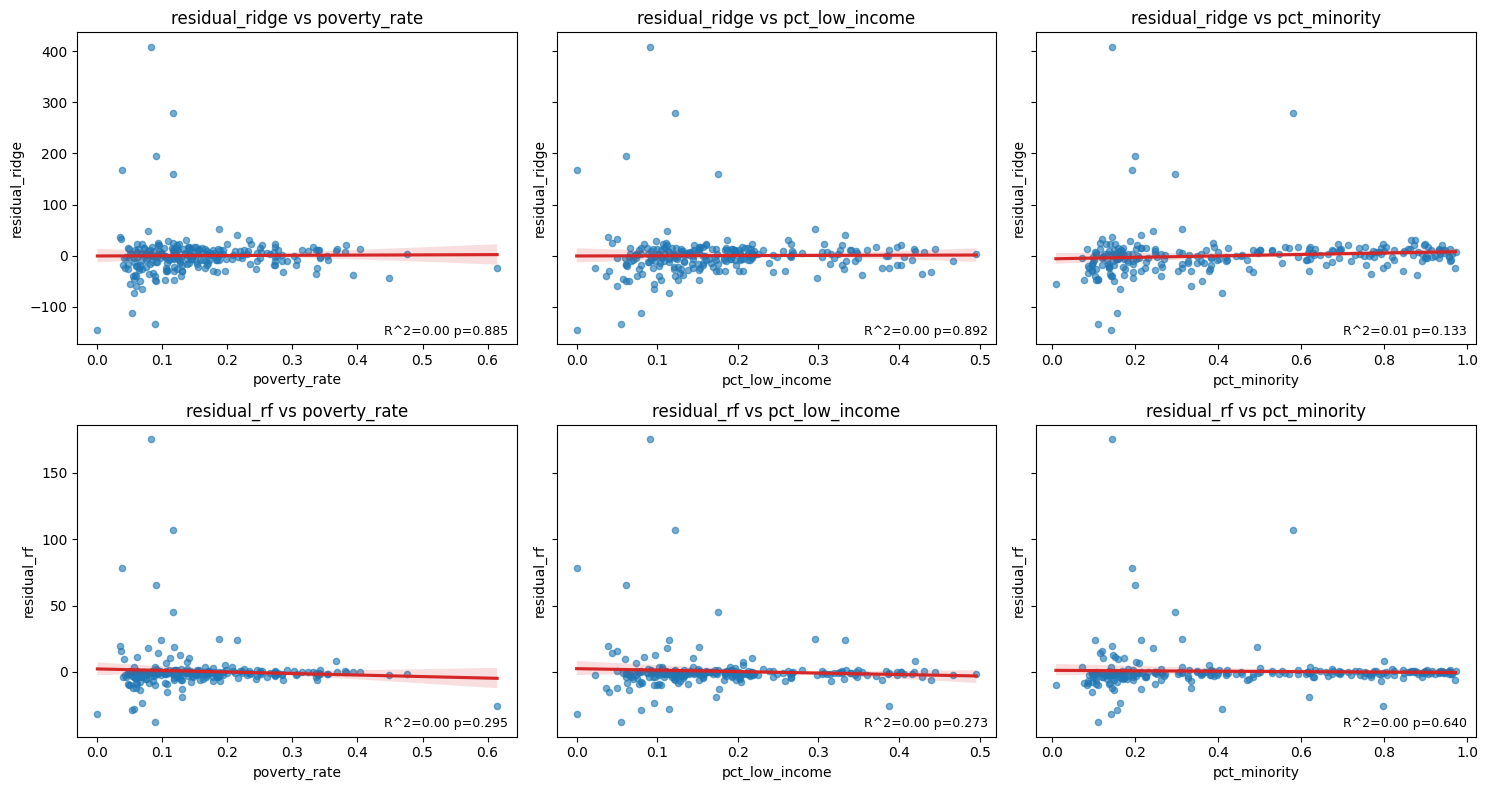

Residual agreement (Ridge vs RF): r=0.915, p=0.000


In [36]:
equity_vars = ['poverty_rate', 'pct_low_income', 'pct_minority']

# Correlation table
results = []
for residual_col in ['residual_ridge', 'residual_rf']:
    for var in equity_vars:
        valid = df_zone[[residual_col, var]].dropna()
        if len(valid) < 2:
            continue
        r, p = pearsonr(valid[residual_col], valid[var])
        results.append({
            'residual': residual_col,
            'variable': var,
            'r': r,
            'r2': r * r,
            'p_value': p
        })

corr_df = pd.DataFrame(results)
print(corr_df)

# Scatter plots with R^2 and p-values
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey='row')
residuals = ['residual_ridge', 'residual_rf']

for i, residual_col in enumerate(residuals):
    for j, var in enumerate(equity_vars):
        ax = axes[i, j]
        sns.regplot(data=df_zone, x=var, y=residual_col, ax=ax,
                    scatter_kws={'s': 20, 'alpha': 0.6}, line_kws={'color': '#d62728'})
        valid = df_zone[[residual_col, var]].dropna()
        if len(valid) > 1:
            r, p = pearsonr(valid[residual_col], valid[var])
            ax.text(
                0.98, 0.02, f"R^2={r*r:.2f} p={p:.3f}",
                transform=ax.transAxes, ha='right', va='bottom', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='none')
            )
        ax.set_title(f"{residual_col} vs {var}")

plt.tight_layout()
plt.show()

# Compare residuals between models
valid_res = df_zone[['residual_ridge', 'residual_rf']].dropna()
if len(valid_res) > 1:
    r_models, p_models = pearsonr(valid_res['residual_ridge'], valid_res['residual_rf'])
    print(f"Residual agreement (Ridge vs RF): r={r_models:.3f}, p={p_models:.3f}")


# 5. Identify underserved zones


In [37]:
underserved = df_zone.nsmallest(10, 'residual_ridge')
cols = ['pulocationid', 'zone', 'borough', 'residual_ridge', 'poverty_rate', 'pct_low_income', 'pct_minority', 'avg_wait_time', 'std_wait_time']
print(underserved[cols])


     pulocationid                                 zone        borough  \
612           110                     Great Kills Park  Staten Island   
506             2                          Jamaica Bay         Queens   
603            99                      Freshkills Park  Staten Island   
600            96            Forest Park/Highland Park         Queens   
558            54                      Columbia Street       Brooklyn   
550            46                          City Island          Bronx   
531            27  Breezy Point/Fort Tilden/Riis Beach         Queens   
608           106                              Gowanus       Brooklyn   
672           170                          Murray Hill      Manhattan   
735           233                  UN/Turtle Bay South      Manhattan   

     residual_ridge  poverty_rate  pct_low_income  pct_minority  \
612     -145.308085      0.000000        0.000000      0.142857   
506     -134.349639      0.088889        0.055556      0.11111

# 6. Choropleths


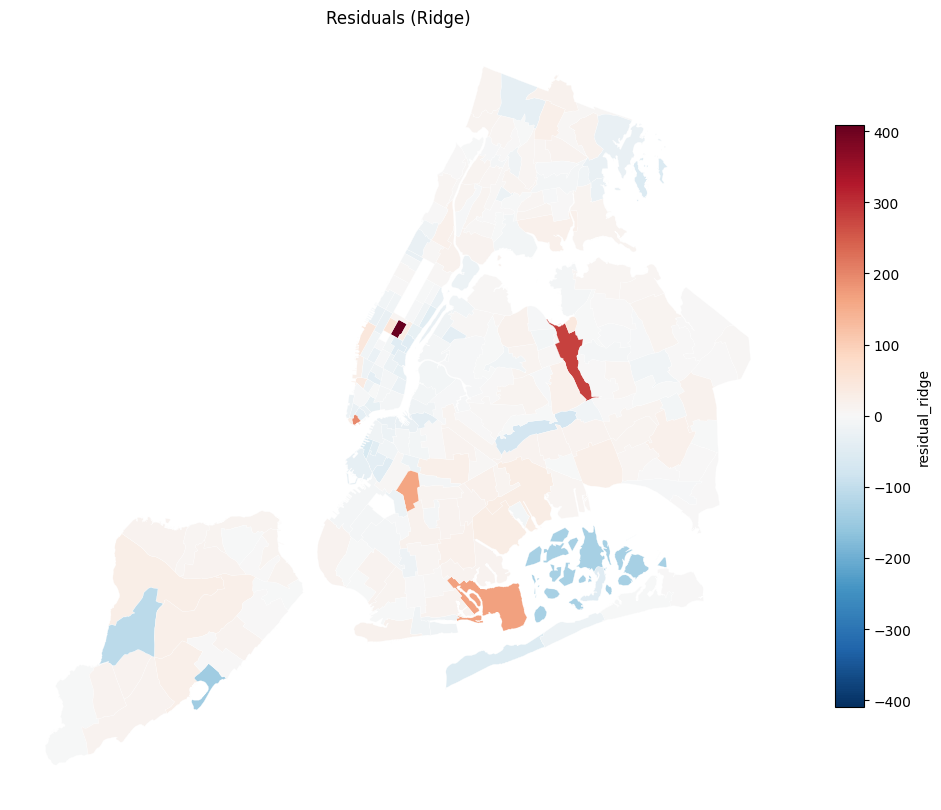

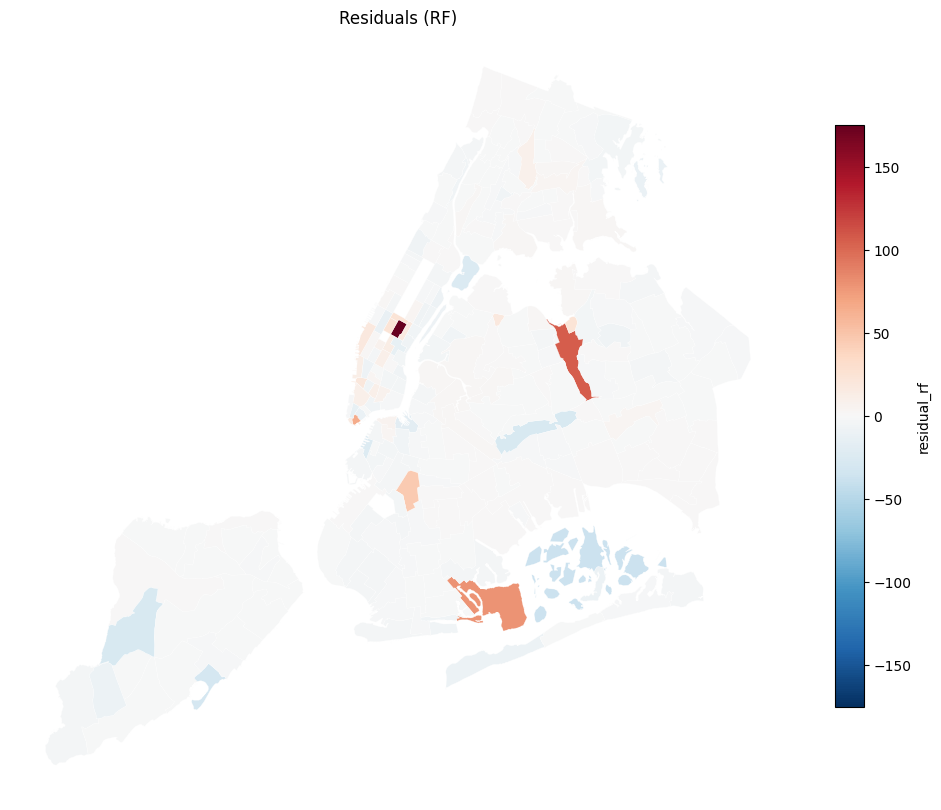

In [38]:
TAXI_ZONES_SHP = Path("../input/raw/shapefiles/taxi_zones/taxi_zones.shp")
gdf_taxi_zones = gpd.read_file(TAXI_ZONES_SHP)
gdf_taxi_zones = gdf_taxi_zones.rename(columns={'LocationID': 'pulocationid'})
gdf_taxi_zones['pulocationid'] = gdf_taxi_zones['pulocationid'].astype(int)

gdf_plot = gdf_taxi_zones.merge(df_zone[['pulocationid', 'residual_ridge', 'residual_rf']], on='pulocationid', how='left')

for col, title in [('residual_ridge', 'Residuals (Ridge)'), ('residual_rf', 'Residuals (RF)')]:
    vals = gdf_plot[col].dropna()
    if len(vals) == 0:
        continue
    max_abs = float(max(abs(vals.min()), abs(vals.max())))

    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_plot.plot(
        column=col,
        ax=ax,
        cmap='RdBu_r',
        linewidth=0.2,
        edgecolor='white',
        legend=True,
        vmin=-max_abs,
        vmax=max_abs,
        legend_kwds={'label': col, 'shrink': 0.6}
    )
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


# 7. Summary findings table


In [39]:
summary = corr_df.copy()
summary['significant'] = summary['p_value'] < 0.05
summary = summary.sort_values(['residual', 'variable'])
print(summary)

         residual        variable         r        r2   p_value  significant
4     residual_rf  pct_low_income -0.069753  0.004866  0.272867        False
5     residual_rf    pct_minority -0.029787  0.000887  0.639953        False
3     residual_rf    poverty_rate -0.066601  0.004436  0.295185        False
1  residual_ridge  pct_low_income  0.008630  0.000074  0.892216        False
2  residual_ridge    pct_minority  0.095379  0.009097  0.133378        False
0  residual_ridge    poverty_rate  0.009245  0.000085  0.884593        False
